# Classification
$$
\renewcommand{\like}{{\cal L}}
\renewcommand{\loglike}{{\ell}}
\renewcommand{\err}{{\cal E}}
\renewcommand{\dat}{{\cal D}}
\renewcommand{\hyp}{{\cal H}}
\renewcommand{\Ex}[2]{E_{#1}[#2]}
\renewcommand{\x}{{\mathbf x}}
\renewcommand{\v}[1]{{\mathbf #1}}
$$

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import sklearn.model_selection

c0=sns.color_palette()[0]
c1=sns.color_palette()[1]
c2=sns.color_palette()[2]

cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

def points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=True, colorscale=cmap_light, 
                cdiscrete=cmap_bold, alpha=0.1, psize=10, zfunc=False, predicted=False):
    h = .02
    X=np.concatenate((Xtr, Xte))
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))

    #plt.figure(figsize=(10,6))
    if zfunc:
        p0 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 0]
        p1 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
        Z=zfunc(p0, p1)
    else:
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    ZZ = Z.reshape(xx.shape)
    if mesh:
        plt.pcolormesh(xx, yy, ZZ, cmap=cmap_light, alpha=alpha, axes=ax)
    if predicted:
        showtr = clf.predict(Xtr)
        showte = clf.predict(Xte)
    else:
        showtr = ytr
        showte = yte
    ax.scatter(Xtr[:, 0], Xtr[:, 1], c=showtr-1, cmap=cmap_bold, 
               s=psize, alpha=alpha,edgecolor="k")
    # and testing points
    ax.scatter(Xte[:, 0], Xte[:, 1], c=showte-1, cmap=cmap_bold, 
               alpha=alpha, marker="s", s=psize+10)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    return ax,xx,yy

def points_plot_prob(ax, Xtr, Xte, ytr, yte, clf, colorscale=cmap_light, 
                     cdiscrete=cmap_bold, ccolor=cm, psize=10, alpha=0.1):
    ax,xx,yy = points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=False, 
                           colorscale=colorscale, cdiscrete=cdiscrete, 
                           psize=psize, alpha=alpha, predicted=True) 
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=ccolor, alpha=.2, axes=ax)
    cs2 = plt.contour(xx, yy, Z, cmap=ccolor, alpha=.6, axes=ax)
    plt.clabel(cs2, fmt = '%2.1f', colors = 'k', fontsize=14, axes=ax)
    return ax 

## A Motivating Example Using `sklearn`: Heights and Weights

We'll use a dataset of heights and weights of males and females to hone our understanding of classifiers. We load the data into a dataframe and plot it.

In [2]:
dflog_orig = pd.read_csv("data/01_heights_weights_genders.csv")
dflog_orig.head()

,Gender,Height,Weight
0,Male,73.847017,241.893563
1,Male,68.781904,162.310473
2,Male,74.110105,212.740856
3,Male,71.730978,220.042470
4,Male,69.881796,206.349801


In [3]:
dflog = pd.read_csv("data/new_list")
dflog.head()

,Gender,Height,Weight,FirstPerson
0,Male,73.847017,241.893563,Adam
1,Male,68.781904,162.310473,Adam
2,Male,74.110105,212.740856,Adam
3,Male,71.730978,220.042470,Adam
4,Male,69.881796,206.349801,Adam


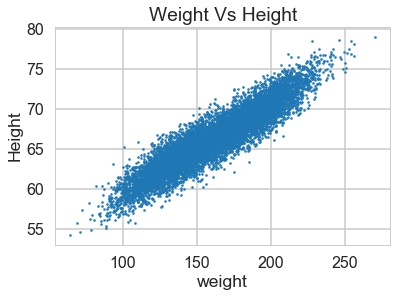

In [4]:
# your turn
plt.scatter(dflog.Weight, dflog.Height,s=4);
plt.xlabel('weight')
plt.ylabel('Height')
plt.title('Weight Vs Height')

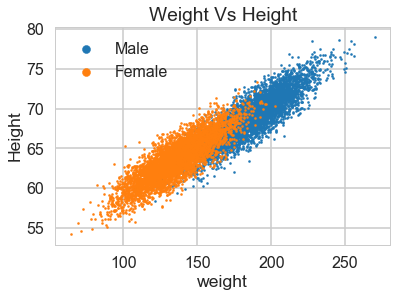

In [5]:
plt.scatter(dflog[dflog.Gender=='Male'].Weight, dflog[dflog.Gender=='Male'].Height,s=4,label='Male');
plt.scatter(dflog[dflog.Gender=='Female'].Weight, dflog[dflog.Gender=='Female'].Height,s=4,label='Female');
plt.xlabel('weight')
plt.ylabel('Height')
plt.title('Weight Vs Height')
plt.legend(fontsize=16,markerscale=4)

In [6]:
categ_att = ["FirstPerson"]

In [7]:
dflog = pd.get_dummies(dflog, prefix=categ_att, columns=categ_att)
dflog.head()

,Gender,Height,Weight,FirstPerson_Adam,FirstPerson_Eve
0,Male,73.847017,241.893563,1,0
1,Male,68.781904,162.310473,1,0
2,Male,74.110105,212.740856,1,0
3,Male,71.730978,220.042470,1,0
4,Male,69.881796,206.349801,1,0


In [8]:
list(dflog.columns)

['Gender', 'Height', 'Weight', 'FirstPerson_Adam', 'FirstPerson_Eve']

In [9]:
list(dflog_orig.columns)

['Gender', 'Height', 'Weight']

In [10]:
(dflog.Gender == "Male").values

array([ True,  True,  True, ..., False, False, False], dtype=bool)

In [11]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
def cv_optimize(clf, parameters, Xtrain, ytrain, n_folds=5):
    gs = sklearn.model_selection.GridSearchCV(clf, param_grid=parameters, cv=n_folds)
    gs.fit(Xtrain, ytrain)
    print("BEST PARAMS", gs.best_params_)
    best = gs.best_estimator_
    return best

In [12]:
from sklearn.model_selection import train_test_split

def do_classify(clf, parameters, indf, featurenames, targetname, target1val, standardize=False, train_size=0.8):
    subdf=indf[featurenames]
    if standardize:
        subdfstd=(subdf - subdf.mean())/subdf.std()
    else:
        subdfstd=subdf
    X=subdfstd.values
    y=(indf[targetname].values==target1val)*1
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=train_size)
    clf = cv_optimize(clf, parameters, Xtrain, ytrain)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print("Accuracy on training data: {:0.2f}".format(training_accuracy))
    print("Accuracy on test data:     {:0.2f}".format(test_accuracy))
    return clf, Xtrain, ytrain, Xtest, ytest

In [13]:
dflog.head()

,Gender,Height,Weight,FirstPerson_Adam,FirstPerson_Eve
0,Male,73.847017,241.893563,1,0
1,Male,68.781904,162.310473,1,0
2,Male,74.110105,212.740856,1,0
3,Male,71.730978,220.042470,1,0
4,Male,69.881796,206.349801,1,0


In [15]:
clf_l, Xtrain_l, ytrain_l, Xtest_l, ytest_l  = do_classify(LogisticRegression(), 
                                                           {"C": [0.01, 0.1, 1, 10, 100]}, 
                                                           dflog, ['Weight', 'Height','FirstPerson_Adam','FirstPerson_Eve'], 'Gender','Female')

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


BEST PARAMS {'C': 1}
Accuracy on training data: 1.00
Accuracy on test data:     1.00


In [33]:
clf_l.coef_

array([[ 0.10322166, -0.25027972,  3.66592623, -3.67168329]])

In [34]:
print(Xtrain_l.shape, ytrain_l.shape, Xtest_l.shape, ytest_l.shape)

(8000, 4) (8000,) (2000, 4) (2000,)


In [35]:
SS_train = Xtrain_l.shape[0] 
SS_test = Xtest_l.shape[0]
PP_train = round(np.sum(ytrain_l)/SS_train,3)
NP_train = round(np.sum(ytrain_l == 0)/SS_train,3)
PP_test = round(np.sum(ytest_l)/SS_test,3)
NP_test = round(np.sum(ytest_l == 0)/SS_test,3)

In [36]:
print(SS_train,SS_test,PP_train,NP_train,PP_test,NP_test)

8000 2000 0.505 0.495 0.479 0.521


In [39]:
from sklearn.metrics import confusion_matrix
cm_test = confusion_matrix(ytest_l,clf_l.predict(Xtest_l))
print(cm_test)
cm_test = pd.DataFrame(cm_test)

[[1042    0]
 [   0  958]]


In [40]:
TN_test = cm_test[0][0];TP_test = cm_test[1][1];FP_test = cm_test[0][1]; FN_test = cm_test[1][0]

In [41]:
TPR_test = round(TP_test/(TP_test+FN_test),3) #true positive rate (Recall)

TNR_test = round(TN_test/(TN_test+FP_test),3) #true negative rate (Specifity)

PPV_test = round(TP_test/(TP_test+FP_test),3) #positive predictive value (Precision)

NPV_test = round(TN_test/(TN_test+FN_test),3) # Negative predictive value

FPR_test = round(FP_test/(FP_test+TN_test),3) # Fall out or false positive rate

FNR_test = round(FN_test/(TP_test+FN_test),3) # False negative rate

FDR_test = round(FP_test/(TP_test+FP_test),3) # False discovery rate

ACC_test = round((TP_test+TN_test)/(TP_test+FP_test+FN_test+TN_test),3) # Overall accuracy

In [42]:
from sklearn.metrics import confusion_matrix
cm_train = confusion_matrix(ytrain_l,clf_l.predict(Xtrain_l))
print(cm_train)
cm_train = pd.DataFrame(cm_train)

[[3958    0]
 [   0 4042]]


In [43]:
TN_train = cm_train[0][0];TP_train = cm_train[1][1];FP_train = cm_train[0][1]; FN_train = cm_train[1][0]

In [44]:
TPR_train = round(TP_train/(TP_train+FN_train),3) #true positive rate (Recall)

TNR_train = round(TN_train/(TN_train+FP_train),3) #true negative rate (Specifity)

PPV_train = round(TP_train/(TP_train+FP_train),3) #positive predictive value (Precision)

NPV_train = round(TN_train/(TN_train+FN_train),3) # Negative predictive value

FPR_train = round(FP_train/(FP_train+TN_train),3) # Fall out or false positive rate

FNR_train = round(FN_train/(TP_train+FN_train),3) # False negative rate

FDR_train = round(FP_train/(TP_train+FP_train),3) # False discovery rate

ACC_train = round((TP_train+TN_train)/(TP_train+FP_train+FN_train+TN_train),3) # Overall accuracy

In [45]:
performance_data = np.array([['','PP','NP','SS','ACCURACY','PRECISION','RECALL','TNR'],
                             ['Training Set',PP_train,NP_train,SS_train,ACC_train,PPV_train,TPR_train,TNR_train],
                             ['Test Set',PP_test,NP_test,SS_test,ACC_test,PPV_test,TPR_test,TNR_test]])

In [46]:
performance_table = pd.DataFrame(data=performance_data[1:,1:],
                      index=performance_data[1:,0],
                      columns=performance_data[0,1:])

In [47]:
performance_table

,PP,NP,SS,ACCURACY,PRECISION,RECALL,TNR
Training Set,0.505,0.495,8000,1.0,1.0,1.0,1.0
Test Set,0.479,0.521,2000,1.0,1.0,1.0,1.0


In [48]:
clf_l_o, Xtrain_l_o, ytrain_l_o, Xtest_l_o, ytest_l_o  = do_classify(LogisticRegression(), 
                                                           {"C": [0.01, 0.1, 1, 10, 100]}, 
                                                           dflog_orig, ['Weight', 'Height'], 'Gender','Male')

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


BEST PARAMS {'C': 0.1}
Accuracy on training data: 0.92
Accuracy on test data:     0.93


In [49]:
clf_l_o.coef_

array([[ 0.19385413, -0.47106824]])

In [50]:
SS_train_o = Xtrain_l_o.shape[0] 
SS_test_o = Xtest_l_o.shape[0]
PP_train_o = round(np.sum(ytrain_l_o)/SS_train_o,3)
NP_train_o = round(np.sum(ytrain_l_o == 0)/SS_train_o,3)
PP_test_o = round(np.sum(ytest_l_o)/SS_test_o,3)
NP_test_o = round(np.sum(ytest_l_o == 0)/SS_test_o,3)

In [51]:
print(SS_train_o,SS_test_o,PP_train_o,NP_train_o,PP_test_o,NP_test_o)

8000 2000 0.501 0.499 0.494 0.505


In [52]:
from sklearn.metrics import confusion_matrix
cm_test_o = confusion_matrix(ytest_l_o,clf_l_o.predict(Xtest_l_o))
print(cm_test_o)
cm_test_o = pd.DataFrame(cm_test_o)

[[933  78]
 [ 70 919]]


In [53]:
TN_test_o = cm_test_o[0][0];TP_test_o = cm_test_o[1][1];FP_test_o = cm_test_o[0][1]; FN_test_o = cm_test_o[1][0]

In [54]:
TPR_test_o = round(TP_test_o/(TP_test_o+FN_test_o),3) #true positive rate (Recall)

TNR_test_o = round(TN_test_o/(TN_test_o+FP_test_o),3) #true negative rate (Specifity)

PPV_test_o = round(TP_test_o/(TP_test_o+FP_test_o),3) #positive predictive value (Precision)

NPV_test_o = round(TN_test_o/(TN_test_o+FN_test_o),3) # Negative predictive value

FPR_test_o = round(FP_test_o/(FP_test_o+TN_test_o),3) # Fall out or false positive rate

FNR_test_o = round(FN_test_o/(TP_test_o+FN_test_o),3) # False negative rate

FDR_test_o = round(FP_test_o/(TP_test_o+FP_test_o),3) # False discovery rate

ACC_test_o = round((TP_test_o+TN_test_o)/(TP_test_o+FP_test_o+FN_test_o+TN_test_o),3) # Overall accuracy

In [55]:
from sklearn.metrics import confusion_matrix
cm_train_o = confusion_matrix(ytrain_l_o,clf_l_o.predict(Xtrain_l_o))
print(cm_train_o)
cm_train_o = pd.DataFrame(cm_train_o)

[[3658  331]
 [ 326 3685]]


In [56]:
TN_train_o = cm_train_o[0][0];TP_train_o = cm_train_o[1][1];FP_train_o = cm_train_o[0][1]; FN_train_o = cm_train_o[1][0]

In [57]:
TPR_train_o = round(TP_train_o/(TP_train_o+FN_train_o),3) #true positive rate (Recall)

TNR_train_o = round(TN_train_o/(TN_train_o+FP_train_o),3) #true negative rate (Specifity)

PPV_train_o = round(TP_train_o/(TP_train_o+FP_train_o),3) #positive predictive value (Precision)

NPV_train_o = round(TN_train_o/(TN_train_o+FN_train_o),3) # Negative predictive value

FPR_train_o = round(FP_train_o/(FP_train_o+TN_train_o),3) # Fall out or false positive rate

FNR_train_o = round(FN_train_o/(TP_train_o+FN_train_o),3) # False negative rate

FDR_train_o = round(FP_train_o/(TP_train_o+FP_train_o),3) # False discovery rate

ACC_train_o = round((TP_train_o+TN_train_o)/(TP_train_o+FP_train_o+FN_train_o+TN_train_o),3) # Overall accuracy

In [58]:
performance_data_o = np.array([['','PP','NP','SS','ACCURACY','PRECISION','RECALL','TNR'],
                             ['Training Set',PP_train_o,NP_train_o,SS_train_o,ACC_train_o,PPV_train_o,TPR_train_o,TNR_train_o],
                             ['Test Set',PP_test_o,NP_test_o,SS_test_o,ACC_test_o,PPV_test_o,TPR_test_o,TNR_test_o]])

In [59]:
performance_table_o = pd.DataFrame(data=performance_data_o[1:,1:],
                      index=performance_data_o[1:,0],
                      columns=performance_data_o[0,1:])

In [60]:
performance_table_o

,PP,NP,SS,ACCURACY,PRECISION,RECALL,TNR
Training Set,0.501,0.499,8000,0.918,0.919,0.918,0.918
Test Set,0.494,0.505,2000,0.926,0.929,0.922,0.93
